# 1. Import Library

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 2. Early Stopping

In [8]:
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


# 3. Dataset Loader

In [9]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\train", transform)
val_ds   = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\val", transform)
test_ds  = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\test", transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

class_names = train_ds.classes

# 4. Model CNN Scratch

# a. Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,1,1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*14*14,256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,4)
        )

    def forward(self,x):
        return self.fc(self.conv(x))


# b. Training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop = EarlyStopping()

train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(50):
    model.train()
    correct = total = loss_sum = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    train_loss.append(loss_sum/len(train_loader))
    train_acc.append(correct/total)

    model.eval()
    correct = total = loss_sum = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)

            loss_sum += loss.item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_loss.append(loss_sum/len(val_loader))
    val_acc.append(correct/total)

    print(f"Epoch {epoch+1} | Train Acc {train_acc[-1]:.4f} | Train Loss {train_loss[-1]:.4f} | Val Acc {val_acc[-1]:.4f} | Val Loss {val_loss[-1]:.4f}")

    if early_stop.step(val_loss[-1]):
        print("Early stopping")
        break

Epoch 1 | Train Acc 0.5840 | Train Loss 0.9021 | Val Acc 0.8625 | Val Loss 0.4147
Epoch 2 | Train Acc 0.8957 | Train Loss 0.2965 | Val Acc 0.9750 | Val Loss 0.0962
Epoch 3 | Train Acc 0.9352 | Train Loss 0.1951 | Val Acc 0.9825 | Val Loss 0.0704
Epoch 4 | Train Acc 0.9400 | Train Loss 0.1696 | Val Acc 0.9750 | Val Loss 0.0814
Epoch 5 | Train Acc 0.9514 | Train Loss 0.1335 | Val Acc 0.9850 | Val Loss 0.0462
Epoch 6 | Train Acc 0.9636 | Train Loss 0.1030 | Val Acc 0.9675 | Val Loss 0.0825
Epoch 7 | Train Acc 0.9650 | Train Loss 0.1035 | Val Acc 0.9850 | Val Loss 0.0427
Epoch 8 | Train Acc 0.9683 | Train Loss 0.0867 | Val Acc 0.9775 | Val Loss 0.0503
Epoch 9 | Train Acc 0.9721 | Train Loss 0.0961 | Val Acc 0.9850 | Val Loss 0.0422
Epoch 10 | Train Acc 0.9688 | Train Loss 0.0798 | Val Acc 0.9875 | Val Loss 0.0399
Epoch 11 | Train Acc 0.9748 | Train Loss 0.0727 | Val Acc 0.9850 | Val Loss 0.0404
Epoch 12 | Train Acc 0.9752 | Train Loss 0.0681 | Val Acc 0.9875 | Val Loss 0.0319
Epoch 13 | Tr

# 5. Evaluasi & Visualisasi

## a. Classification Report

In [13]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for x,y in test_loader:
        out = model(x.to(device))
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Dark       1.00      0.98      0.99       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       0.98      1.00      0.99       100

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



## b. Grafik Loss & Accuracy

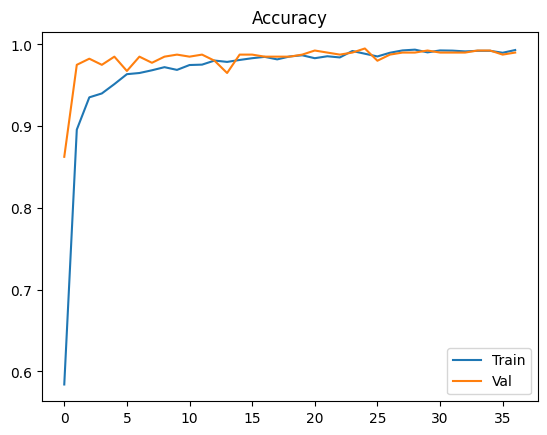

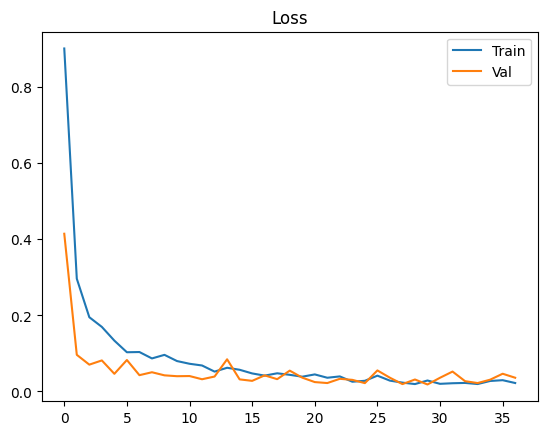

In [14]:
plt.plot(train_acc,label="Train")
plt.plot(val_acc,label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss,label="Train")
plt.plot(val_loss,label="Val")
plt.title("Loss")
plt.legend()
plt.show()


## c. Confusion Matrix

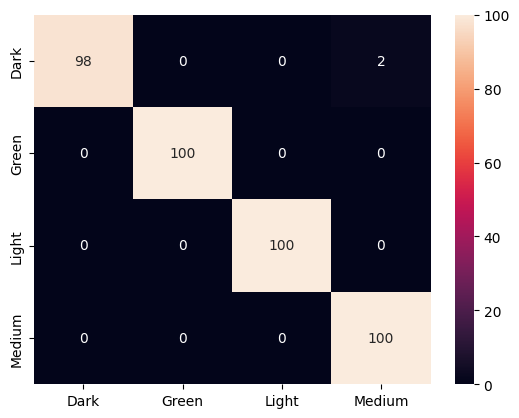

In [15]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
plt.show()

In [17]:
torch.save(model.state_dict(), r"C:\Users\IKBAR\uap_ML\src\model\cnn_scratch.pkl")